In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gene_sample_file = "BRCA.combinedData.txt"

gene_sample_df = pd.read_csv(
    gene_sample_file,
    sep="\s+",
    header=None,
    names=["row", "column", "mutation", "gene", "sample"],
    skiprows=1
)

# Extract the original order of samples and genes
sample_order = gene_sample_df['sample'].drop_duplicates().tolist()
gene_order = gene_sample_df['gene'].drop_duplicates().tolist()

gene_sample_pivot = gene_sample_df.pivot_table(
    index="gene",
    columns="sample",
    values="mutation",
    aggfunc='first',
    fill_value=0
)

gene_sample_pivot = gene_sample_pivot.reindex(index=gene_order, columns=sample_order)

# Display the results
print("Number of rows (genes):", gene_sample_pivot.shape[0])
print("Number of columns (samples):", gene_sample_pivot.shape[1])

print("Updated Gene-Sample Mutation Matrix:")
gene_sample_pivot.head()


Number of rows (genes): 20131
Number of columns (samples): 948
Updated Gene-Sample Mutation Matrix:


sample,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5T-A9QA,TCGA-A1-A0SD,TCGA-A1-A0SE,TCGA-A1-A0SJ,TCGA-A1-A0SM,...,normal_382,normal_389,normal_390,normal_401,normal_403,normal_404,normal_411,normal_428,normal_430,normal_431
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000283088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000167617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000166787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ENSG00000166104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000164845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
non_normal_columns = [col for col in gene_sample_pivot.columns if col.startswith('TCGA')]
non_zero_counts_per_row = (gene_sample_pivot[non_normal_columns] != 0).sum(axis=1)
print("\nNumber of non-zero entries per gene (excluding 'normal' samples):")
print(non_zero_counts_per_row)


Number of non-zero entries per gene (excluding 'normal' samples):
gene
ENSG00000283088      0
ENSG00000167617      0
ENSG00000166787      0
ENSG00000166104      0
ENSG00000164845      0
                  ... 
ENSG00000145113    587
ENSG00000197915    591
ENSG00000104974    603
ENSG00000205277    607
ENSG00000184956    703
Length: 20131, dtype: int64


In [52]:
# Calculate total entries in the matrix
total_entries = gene_sample_pivot.size

# Calculate the number of zero entries
zero_entries = (gene_sample_pivot == 0).sum().sum()

# Calculate sparsity
sparsity = zero_entries / total_entries

print(f"Sparsity of the gene-sample mutation matrix: {sparsity:.2%}")


Sparsity of the gene-sample mutation matrix: 96.42%


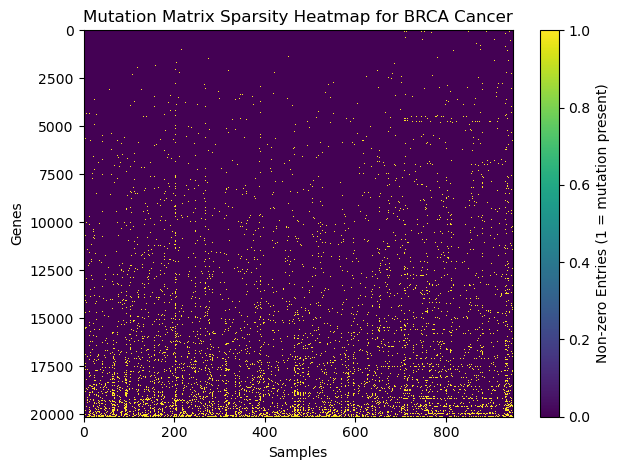

In [4]:
#plt.figure(figsize=(12, 8))
plt.imshow(gene_sample_pivot != 0, cmap="viridis", aspect="auto", interpolation="nearest")
plt.colorbar(label="Non-zero Entries (1 = mutation present)")
plt.title("Mutation Matrix Sparsity Heatmap for BRCA Cancer")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()

In [54]:
# Initialize sets for TCGA and normal columns
tcga_columns = set(col for col in gene_sample_pivot.columns if col.startswith("TCGA"))
normal_columns = set(col for col in gene_sample_pivot.columns if col.startswith("normal"))
all_genes = []

# Initialize sets to track unique values for TCGA and normal
unique_values_tumor = set()
unique_values_normal = set()
line_count = 0

# Process the file
with open("solution_4hit.txt", "r") as file:
    for line in file:
        # Split the line to get row names and filter DataFrame
        row_names = line.strip().split(", ")
        all_genes.extend(row_names)
        filtered_df = gene_sample_pivot.loc[row_names]
        intersection = set(filtered_df.columns[(filtered_df > 0).all()])

        # Update unique values for both TCGA and normal
        unique_values_tumor.update(intersection)
        unique_values_normal.update(intersection)

        line_count += 1

        # Calculate current coverage for logging
        tumor_coverage = len(unique_values_tumor & tcga_columns)
        normal_coverage = len(unique_values_normal & normal_columns)

        print(f"Line {line_count}: Tumor coverage: {tumor_coverage} / {len(tcga_columns)}, "
              f"Normal coverage: {normal_coverage} / {len(normal_columns)}")

        # Break early if all TCGA columns are covered
        if tcga_columns.issubset(unique_values_tumor):
            print(f"All TCGA columns are covered at line {line_count}.")
            break

# Final coverage checks
if tcga_columns.issubset(unique_values_tumor):
    print("All TCGA columns are covered.")
else:
    print(f"Some TCGA columns are missing. Covered: {len(unique_values_tumor & tcga_columns)} / {len(tcga_columns)}")

normal_coverage = len(unique_values_normal & normal_columns)
total_normal = len(normal_columns)
if normal_columns.issubset(unique_values_normal):
    print("All normal columns are covered.")
else:
    print(f"Some normal columns are missing. Covered: {normal_coverage} / {total_normal} "
          f"({(normal_coverage / total_normal) * 100:.2f}%)")

Line 1: Tumor coverage: 31 / 55, Normal coverage: 0 / 254
Line 2: Tumor coverage: 46 / 55, Normal coverage: 0 / 254
Line 3: Tumor coverage: 53 / 55, Normal coverage: 0 / 254
Line 4: Tumor coverage: 55 / 55, Normal coverage: 0 / 254
All TCGA columns are covered at line 4.
All TCGA columns are covered.
Some normal columns are missing. Covered: 0 / 254 (0.00%)


In [55]:
all_genes = list(set(all_genes))
random_genes = ['ENSG00000005381', 'ENSG00000135537', 'ENSG00000135521', 'ENSG00000135506', 'ENSG00000135503']
all_genes.extend(random_genes)

filtered_df = gene_sample_df[gene_sample_df['gene'].isin(all_genes)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.to_csv(
    "filtered_ACC.combinedData_sorted.txt",
    sep=' ',
    header=False,
    index=False
)